# Lorenz-System

Ein Projekt im Rahmen der VU "Numerische Methoden für Differentialgleichungen"

von Clemens Eckl, Johannes Zischg, Emil Becker und Maximilian Stollmayer

### Einleitung

_wer was wann warum_

Edward N. Lorenz (1917-2008) vereinfachte 1963 ein Modell der Atmosphäre von 12 Variablen und 12 Gleichungen zu einem idealisierten hydrodynamischen System von nur mehr 3 Gleichungen:

\begin{cases}
    \dfrac{\mathrm{d} x}{\mathrm{d} t} = \rho (x - y) \\
    \dfrac{\mathrm{d} y}{\mathrm{d} t} = x (r - z) - y \\
    \dfrac{\mathrm{d} z}{\mathrm{d} t} = x y - b z
\end{cases}

Butterfly Effect ...

### Numerische Analyse

_Emil_

### Euler-Methode

_Clemens_

MATLAB Code test
```octave
tx = linspace (-8, 8, 41);
ty = tx;
[xx, yy] = meshgrid (tx, ty);
r = sqrt (xx .^ 2 + yy .^ 2) + eps;
tz = sin (r) ./ r;
```

### Runge-Kutte 4

_Johannes_

### Prädiktor-Korrektor-Verfahren

Die Idee des Prädiktor-Korrektor-Verfahrens ist die Kombination von expliziten und impliziten Verfahren um gute Konvergenzeigenschaften zu erhalten, ohne dabei den Rechenleistungspreis der impliziten Verfahren zu zahlen.

Dazu wird als Prädiktor ein Schritt eines expliziten Verfahrens ausgeführt und das Ergebnis in den Korrektor, einer impliziten Gleichung, eingesetzt um kein Gleichungssystem lösen zu müssen.

Bei Einschrittverfahren sieht die Prädiktor-Evaluierung-Korrektor-Evaluierung Schleife wie folgt aus:

\begin{align*}
&(P) \qquad \tilde{y}_{n+1} = y_n + h \ \Phi_P(t_n,\, y_n,\, f_n,\, h) \\
&(E) \qquad \tilde{f}_{n+1} = f(t_{n+1},\, \tilde{y}_{n+1}) \\
&(C) \qquad y_{n+1} = y_n + h \ \Phi_C(t_n,\, y_n,\, \tilde{y}_{n+1},\, f_n,\, \tilde{f}_{n+1},\, h) \\
&(E) \qquad f_{n+1} = f(t_{n+1},\, y_{n+1})
\end{align*}

Wobei hier $\Phi_P$ das explizite und $\Phi_C$ das implizite Einschrittverfahren bezeichnet.

Um die Genauigkeit zu erhöhren, kann man z.B. nun den Korrektor mehrmals anwenden und kommt so zu dem Modus PE(CE)$^k$ bzw. wenn man ihn so oft anwendet bis Konvergenz zu einer gewünschten Toleranz vorliegt: PE(CE)$^\infty$.

Oft verwendete Prädiktor-Korrektor-Verfahren:
- Methode von Heun: explizites Euler-Verfahren als Prädiktor und Crank-Nicolson als Korrektor
- ABM: Adams-Bashforth als Prädiktor und Adams-Moulton als Korrektor

Die Kombination von Adams-Bashforth und Adams-Moulton wurde hier als Mischung aus PE(CE)$^k$ und PE(CE)$^\infty$ implementiert und ein Schritt läuft so ab:

\begin{align*}
&(P) \qquad \tilde{y}_{n+1} = y_n + h \ \sum_{j=0}^s a_j \ f(t_{n-j},\, y_{n-j}) \\
&(C) \qquad y_{n+1} = y_n + h \ \sum_{j=0}^{s-1} b_j \ f(t_{n-j},\, y_{n-j}) + h \ b_{-1} \ f(t_{n+1},\, \tilde{y}_{n+1})
\end{align*}

Dabei ist $s$ die Anzahl der Schritte und $(a_j)_{j=0}^s$ sowie $(b_j)_{j=-1}^{s-1}$ die Koeffizienten der Mehrschrittverfahren, die man aus einer Polynominterpolation gewinnt.

(C) wird hier so oft wiederholt bis die gewünschte Konvergenz oder die vorgegebene Anzahl an Zyklen erreicht ist.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))

In [13]:
class LorenzSystem:
    
    def __init__(self, rho, r, b):
        '''initialize an object with the parameters rho, r and b for the ODE'''
        
        self.rho = rho
        self.r = r
        self.b = b
                
    def ODE(self, state):
        '''
        returns the rate of change of each state component
        
        state ... array of the form [x, y, z]
        '''
        
        x, y, z = state
        return np.array([self.rho*(x-y), x*(self.r-z)-y, x*y-self.b*z])
    
    def solve(self, state0, h=0.01, N=5000, steps=5, iters=1, tol=0.01):
        '''
        solves the ODE with given initial state and discretized time interval using ABM
        
        state0 ... initial state vector [x, y, z]
        h ........ step size
        N ........ number of time steps
        steps .... number of interpolation steps per time step
        iters .... number of iterations for each evaluation-correction cycle
        tol ...... if this tolerance is exceeded the evaluation-correction cycle breaks
        '''
        
        state0 = np.array(state0)
        s = steps if 0 < steps < 5 else 5
        iters = int(iters) if 0 < iters else 1
        
        # initialize state array with initial state
        states = np.zeros((N+1, 3))
        states[0] = state0
        
        # initialize ODE function values
        fvals = np.zeros((N+1, 3))
        fvals[0] = self.ODE(state0)
        
        # coefficients for Adams-Bashforth method
        coeffsAB = (1,
                    [-1/2, 3/2],
                    [5/12, -16/12, 23/12],
                    [-9/24, 37/24, -59/24, 55/24],
                    [251/720, -1274/720, 2616/720, -2774/720, 1901/720])
        
        # coefficients for Adams-Moulton method
        coeffsAM = (1,
                    [1/2, 1/2],
                    [-1/12, 2/3, 5/12],
                    [1/24, -5/24, 19/24, 9/24],
                    [-19/720, 106/720, -264/720, 646/720, 251/720])
        
        # increasing steps until desired order is reached
        for n in range(s):
            # predictor: Adams-Bashforth method
            states[n+1] = states[n] + h * np.dot(coeffsAB[n], fvals[:n+1])
            
            # evaluation
            fvals[n+1] = self.ODE(states[n+1])
            
            # correction-evaluation cycle with Adams-Moulton
            for i in range(iters):
                new = states[n] + h * np.dot(coeffsAM[n], fvals[:n+1])
                cond = np.allclose(states[n+1], new, atol=tol)
                states[n+1] = new
                fvals[n+1] = self.ODE(states[n+1])
                if cond:
                    break
        
        # main loop
        for n in range(s, N):
            # predictor: Adams-Bashforth method
            states[n+1] = states[n] + h * np.dot(coeffsAB[s-1], fvals[n-s+1:n+1])
            
            # evaluation
            fvals[n+1] = self.ODE(states[n+1])
            
            # correction-evaluation cycle with Adams-Moulton
            for i in range(iters):
                new = states[n] + h * np.dot(coeffsAM[s-1], fvals[n-s+2:n+2])
                cond = np.allclose(new, states[n+1], atol=tol)
                states[n+1] = new
                fvals[n+1] = self.ODE(states[n+1])
                if cond:
                    break
        
        return states
    
    def plot(self, *args, h=0.01, N=5000, steps=5, iters=1, tol=0.01, parametric=True):
        '''
        plots the solved system for multiple initial conditions
        
        *args ... any number of initial states [x0, y0, z0], ...
        h, N, steps, iters, tol ... same as in the "solve" method
        parametric ... True/False determines if system is parametrically plotted on a 3D axis or if each
                       state component gets plottet on a time axis
        '''
        
        if parametric:
            fig = plt.figure()
            ax = fig.gca(projection="3d")

            ax.w_xaxis.pane.set_color("w")
            ax.w_yaxis.pane.set_color("w")
            ax.w_zaxis.pane.set_color("w")
            ax.set_xlabel("x Axis")
            ax.set_ylabel("y Axis")
            ax.set_zlabel("z Axis")
            ax.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=16)

            for state in args:
                states = self.solve(state, h=h, N=N)
                ax.plot(*states.T, linewidth=0.5, alpha=0.95, label=f"initial state {state}")

            plt.legend()
            plt.show()
            
        else:
            fig = plt.figure()
            ax1 = fig.add_subplot(3, 1, 1, xticklabels=[])
            ax2 = fig.add_subplot(3, 1, 2, xticklabels=[])
            ax3 = fig.add_subplot(3, 1, 3)
            
            ax1.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=24)
            ax1.set_ylabel("x Axis")
            ax2.set_ylabel("y Axis")
            ax3.set_xlabel("time")
            ax3.set_ylabel("z Axis")
            
            t = h * np.arange(N+1)
            
            for i, state in enumerate(args):
                states = self.solve(state, h=h, N=N)
                ax1.plot(t, states.T[0], color=f"C{i}", linewidth=1, alpha=0.95, label=f"initial state {state}")
                ax2.plot(t, states.T[1], color=f"C{i}", linewidth=1, alpha=0.95)
                ax3.plot(t, states.T[2], color=f"C{i}", linewidth=1, alpha=0.95)
            
            ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=len(args), mode="expand", borderaxespad=0)
            plt.show()

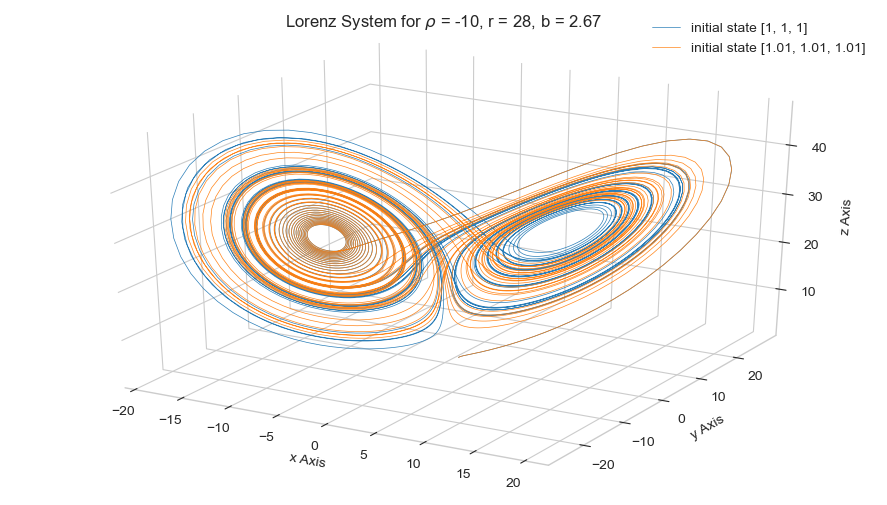

In [14]:
rho = -10
r = 28
b = 8 / 3

state1 = [1, 1, 1]
state2 = [1.01, 1.01, 1.01]

LS = LorenzSystem(rho, r, b)
LS.plot(state1, state2)

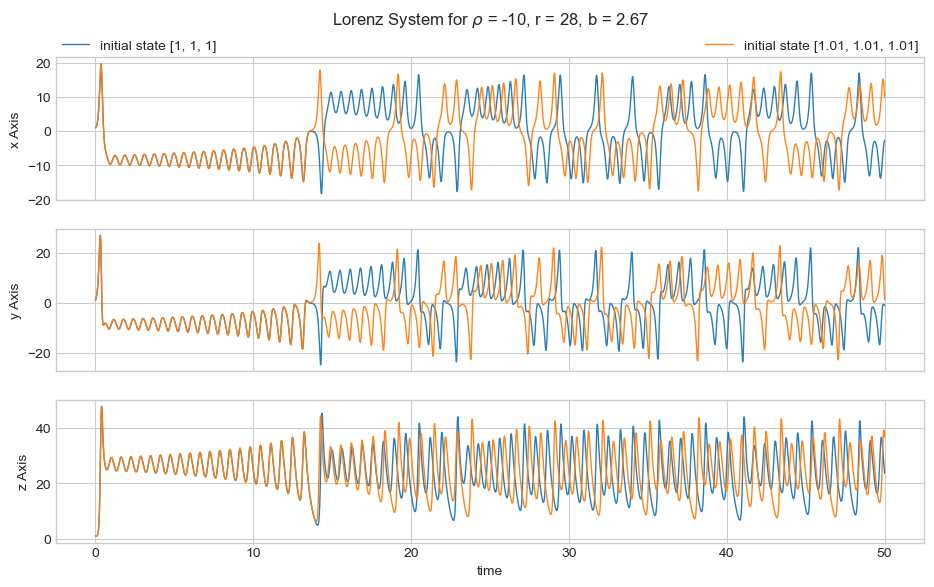

In [16]:
LS.plot(state1, state2, parametric=False)

### Beobachtungen

schaut leiwand aus

„bei gleicher Schrittweite ist Euler explizit ganz schlecht, weil…

Runge-Kutte 4 besser aber auch nicht gut, weil …

Prediktor-Korrektor sehr gut, was man daran erkennt…

Wir erklären uns das so: …“

### Quellen

[Wikipedia Lorenz-System](https://en.wikipedia.org/wiki/Lorenz_system)

[Wikipedia Predictor-corrector method](https://en.wikipedia.org/wiki/Predictor–corrector_method)